<a href="https://colab.research.google.com/github/AnJejune/DeepLearning/blob/main/HowToUseTestSet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier

In [ ]:
cancer = load_breast_cancer()
x = cancer.data
y = cancer.target
x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=42)

In [ ]:
sgd = SGDClassifier(loss='log', random_state=42)
sgd.fit(x_train_all, y_train_all)
sgd.score(x_test, y_test)
# 테스트 세트의 정확도는 약 83%, 이 성능이 마음에 않들면 다른 손실함수 사용 가능

0.8333333333333334

In [ ]:
# 하이퍼 파라미터인 loss값을 바꾸고 성능 검사
sgd = SGDClassifier(loss='hinge', random_state=42)
sgd.fit(x_train_all, y_train_all)
sgd.score(x_test, y_test)
# loss의 값을 hinge -> SVM(Support Vector Machine)으로 바꿨을 떄 93%

0.9385964912280702

loss의 값을 바꾸는 것을 모델을 튜닝한다고 한다.           
하지만, 테스트 세트로 모델을 튜닝하는 것은 실전에서 좋은 성능을 기대하기 어렵다.             
테스트 세트는 모델의 성능을 측정하기 위함일 뿐, 테스트 세트를 튜닝한다고 해서 테스트 세트에만 좋은 모델이 된다.


In [ ]:
# 해결법 : 테스트 세트는 모델 튜닝을 모두 마치고 마지막으로 한 번만 사용하는 것이 좋으며,
# 훈련세트를 줄이고 검증세트를 새로 만들어 검증세트에 튜닝을 진행한다.

# 검증세트 분할하기
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify = y_train_all, test_size=0.2, random_state=42)
print(len(x_train), len(x_val)) # 훈련세트가 훈련세트, 테스트 세트로 나뉜 뒤 다시 훈련세트가 훈련세트(8) : 검증세트(2)로 나뉨 

364 91


In [ ]:
# 검증 세트 사용해 모델 평가하기
sgd = SGDClassifier(loss='log', random_state=42)
sgd.fit(x_train, y_train)
sgd.score(x_val, y_val)

0.6923076923076923

아까보다 데이터 양이 적어 성능이 줄어들었다.

데이터 가공, 특성의 스케일(값의 범위)이 다른 데이터를 위한 '데이터 전처리'

# 특성의 스케일이 다른 데이터를 스케일 조정하지 않고 모델을 훈련

['mean perimeter' 'mean area']


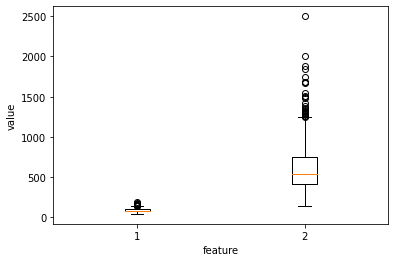

In [ ]:
# 훈련 데이터 준비, 스케일 비교
print(cancer.feature_names[[2,3]])
plt.boxplot(x_train[:,2:4])
plt.xlabel('feature')
plt.ylabel('value')
plt.show() # 두 특성의 스케일 차이가 큰 지 확인

In [ ]:
class SingleLayer:

  # 가중치를 기록할 변수와 학습률 파라미터 추가
  def __init__(self, learning_rate=0.1): 
    self.w = None 
    self.b = None
    self.losses = [] # 손실함수의 결과 값을 저장할 리스트
    self.w_history = [] # 에포크마다 가중치의 값
    self.lr = learning_rate # 학습률 하이퍼 파라미터(learning_rate)(0.01, 0.001 등등 로그 스케일로 지정)

  def forpass(self, x):
    z = np.sum(x * self.w) + self.b     # 직선 방정식 계산
    return z
  
  def backprop(self, x, err):
    w_grad = x * err
    b_grad = 1 * err
    return w_grad, b_grad
  

  # 가중치를 기록하고 업데이트 양 조절하기
  def fit(self, x, y, epochs=100):  

    self.w = np.ones(x.shape[1]) # 가중치를 초기화
    self.b = 0  # 절편을 초기화
    self.w_history.append(self.w.copy()) # 가중치를 기록
    np.random.seed(42) # 무작위로 시드를 지정

    for i in range(epochs):
      loss = 0
      indexes = np.random.permutation(np.arange(len(x))) # 인덱스 섞기

      for i in indexes: # 모든 샘플에 대해 반복
        z = self.forpass(x[i]) # 직선 방정식 적용( 정방향 계산 ) 
        a = self.activation(z) # 활성화 함수 적용
        err = -(y[i] - a); # 오차계산 => 로지스틱 손실 함수 미분값 
        w_grad, b_grad = self.backprop(x[i], err) # 역방향 계산
        self.w -= self.lr * w_grad # 가중치 업데이트(학습률 적용)
        self.b -= b_grad
        self.w_history.append(self.w.copy()) # 가중치 기록
        a = np.clip(a, 1e-10, 1-1e-10) # 안전한 로그 계산을 위해 클리핑 후 손실을 누적
        loss += -(y[i]*np.log(a) + (1-y[i]) * np.log(1-a))
      self.losses.append(loss/len(y))  # 에포크마다 평균 손실을 저장
  
  def activation(self, z): # 활성화 함수 구현 (z값은 np(배열)로 넘어옴)
    z = np.clip(z, -100, None)
    a = 1 / (1 + np.exp(-z)) # 시그모이드 함수
    return a
  
  def predict(self, x): # 예측 메서드 구현
    z = [self.forpass(x_i) for x_i in x] # 선형 함수 적용 
    return np.array(z) > 0 # 스템 함수 적용
    # z가 0보다 크면 시그모이드 함수의 출력값은 0.5보다 크고 작으면 0.5보다 작으므로 굳이 시그모이드 함수를 사용하지 않아도 된다.

  def score(self, x, y): # 정확도 출력 
    return np.mean(self.predict(x) ==  y)


학습률이 너무 높으면 가중치의 변화가 크므로 전역 최솟값을 지나칠 수 있다.      
학습률이 적절해야 가중치의 변화가 안정적이므로 전역 최솟값에 도달한다.

In [ ]:
# 모델 훈련하고 평가하기
layer1 = SingleLayer()
layer1.fit(x_train, y_train)
layer1.score(x_val, y_val)

0.9120879120879121

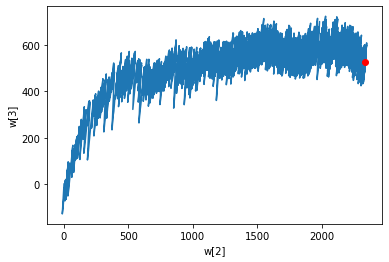

In [ ]:
w2 = []
w3 = []
for w in layer1.w_history:
    w2.append(w[2])
    w3.append(w[3])
plt.plot(w2, w3)
plt.plot(w2[-1], w3[-1], 'ro')
plt.xlabel('w[2]')
plt.ylabel('w[3]')
plt.show()
# w3는 큰 폭으로 흔들리고 w2는 최적의 값을 찾아감 
# w3에 대한 그레이디언트가 크기 때문에 w3축을 따라 가중치가 크게 요동친다. => 해결방안 : 스케일 조정(튜닝)

In [ ]:
# 스케일을 조정해 모델을 훈련
# 신경만에서 자주 사용하는 조정 방법은 '표준화(특성값에서 평균을 빼고 표준편차로 나눈 값)'입니다. => z(표준화) = x(특성값) - μ(평균)/ s(표준편차)

# 넘파이로 표준화 구현
train_mean = np.mean(x_train, axis=0) # 평균
train_std = np.std(x_train, axis=0) # 표준편차
# axis=0 -> 2차원 배열의 열을 기준으로 통계치를 계산, 하나의 행 벡터로 반환

x_train_scaled = (x_train - train_mean) / train_std  # 표준화

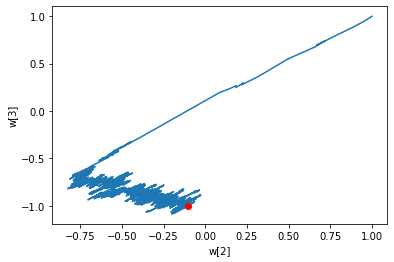

In [ ]:
# 모델 훈련하기
layer2 = SingleLayer()
layer2.fit(x_train_scaled, y_train)
w2 = []
w3 = []

for w in layer2.w_history:
  w2.append(w[2])
  w3.append(w[3])

plt.plot(w2, w3)
plt.plot(w2[-1], w3[-1], 'ro')
plt.xlabel('w[2]')
plt.ylabel('w[3]')
plt.show()

# w2와 w3의 변화 비율이 비슷하여 대각선 방향으로 가중치가 이동, 또한 두 특성의 스케일을 비슷하게 맞추어 최적값에 빠르게 근접

In [ ]:
# 모델 성능 평가
layer2.score(x_val, y_val)
# 매우 않좋음

0.37362637362637363

In [ ]:
# 훈련 세트의 스케일만 바꾸었고 검증 세트의 스케일은 바뀌지 않았기 때운
# 검증 세트도 표준화 전처리 적용

val_mean = np.mean(x_val, axis=0) # 평균
val_std = np.std(x_val, axis=0) # 표준편차
# axis=0 -> 2차원 배열의 열을 기준으로 통계치를 계산, 하나의 행 벡터로 반환

x_val_scaled = (x_val - val_mean) / val_std  # 표준화
layer2.score(x_val_scaled, y_val) # 표준화를 적용한 x_val_scaled -> 성능 96%

0.967032967032967

스케일을 조정한 다음 실수하기 쉬운 함정

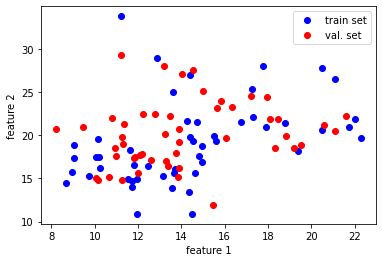

In [ ]:
# 원본 훈련 세트와 검증 세트에서 데이터 50개씩 뽑아 산점도 그리기
plt.plot(x_train[:50, 0], x_train[:50, 1], 'bo')
plt.plot(x_val[:50, 0], x_val[:50, 1], 'ro')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.legend(['train set', 'val. set'])
plt.show()

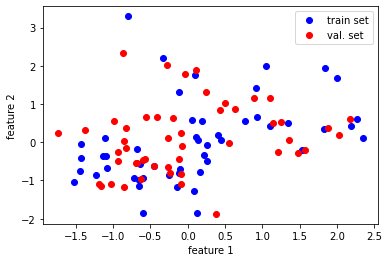

In [ ]:
# 전처리한 훈련세트와 검증 세트 산점도
plt.plot(x_train_scaled[:50, 0], x_train_scaled[:50, 1], 'bo')
plt.plot(x_val_scaled[:50, 0], x_val_scaled[:50, 1], 'ro')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.legend(['train set', 'val. set'])
plt.show()


두 그래프를 비교했을 때 점 사이 거리가 미묘한 차이가 있음 : 데이터를 제대로 전처리 했다면 train set과 val set 거리가 그대로 유지되어야 한다.      
차이가 나는 이유 : 훈련세트와 검증 세트를 각각 다른 비율로 전처리했기 때문


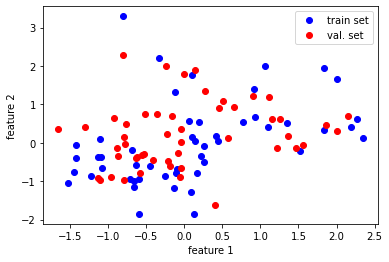

In [ ]:
# 해결방안 : 훈련 세트의 평균, 표춘편차를 사용하여 검증 세트를 변환하면 해결할 수 있다. ... 근데 왜??
x_val_scaled = (x_val - train_mean) / train_std

plt.plot(x_train_scaled[:50, 0], x_train_scaled[:50, 1], 'bo')
plt.plot(x_val_scaled[:50, 0], x_val_scaled[:50, 1], 'ro')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.legend(['train set', 'val. set'])
plt.show()

# 훈련세트와 검증 세트 모델의 과대적합, 과소적합 문제


과대적합 : 모델이 훈련 세트에서는 좋은 성능을 내지만 검증 세트에서는 낮은 성능을 내는 경우 ( 훈련 세트와 검증 세트의 성능 차이가 크다 )              
과소적합 : 훈련세트, 검증 세트의 성능 차이가 크지 않지만 모두 낮은 성능을 내는 경우

과대적합 원인 :         
1. 훈련 세트에 다양한 패턴의 샘플이 없어 검증 세트에 제대로 적응하지 못함. => 더 많은 훈련 샘플을 모아 검증 세트의 성능을 향상
2. 훈련 세트를 더 많이 모을 수 없는 경우 => 모델이 훈련 세트에 집착하지 않도록 가중치를 제한 = '모델의 복잡도를 낮춘다'

과소적합 원인 : 
1. 모델이 단순해 훈련 데이터에 있는 패턴을 모두 잡아내지 못함. => 모델을 복잡하게 하거나 가중치의 규제를 완화한다.


에포크와 손실 함수 그래프로 과대적합, 과소적합을 찾을 수 있다.

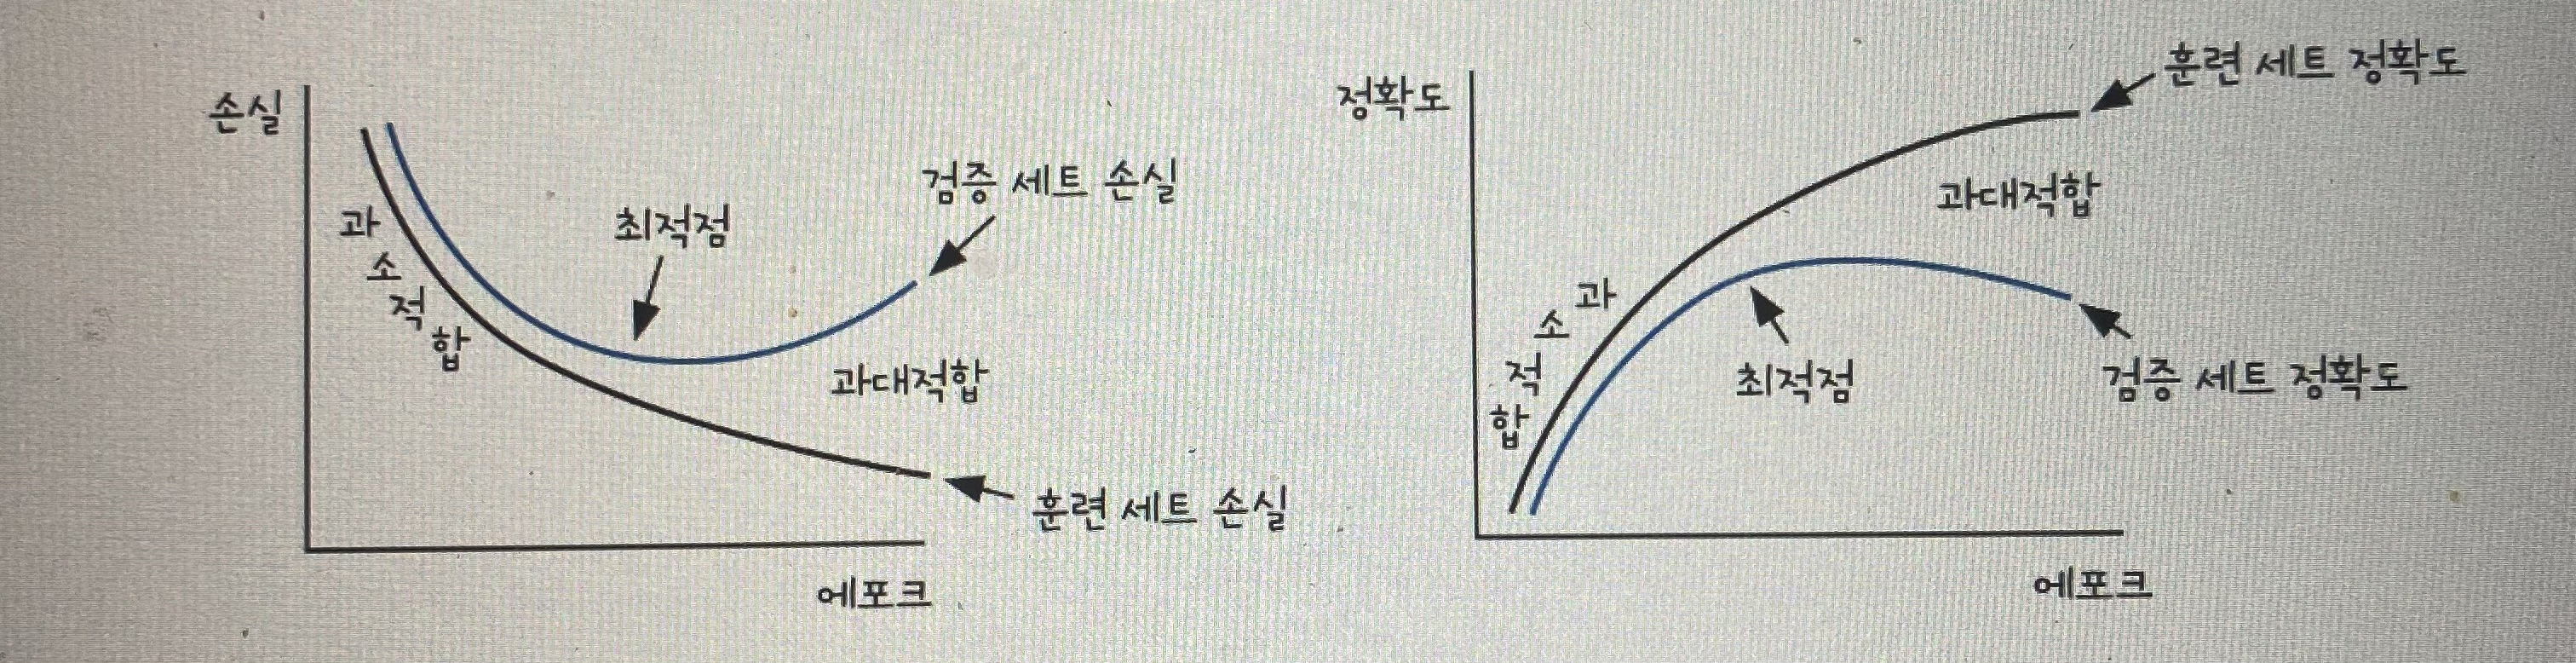

최적점을 지난 이후에도 계속해서 훈련세트로 모델을 학습시키면 모델이 훈련세트의 샘플에 더 밀착하여 학습히기 때문에 오히려 상승한다.

모델 복잡도와 손실함수 그래프

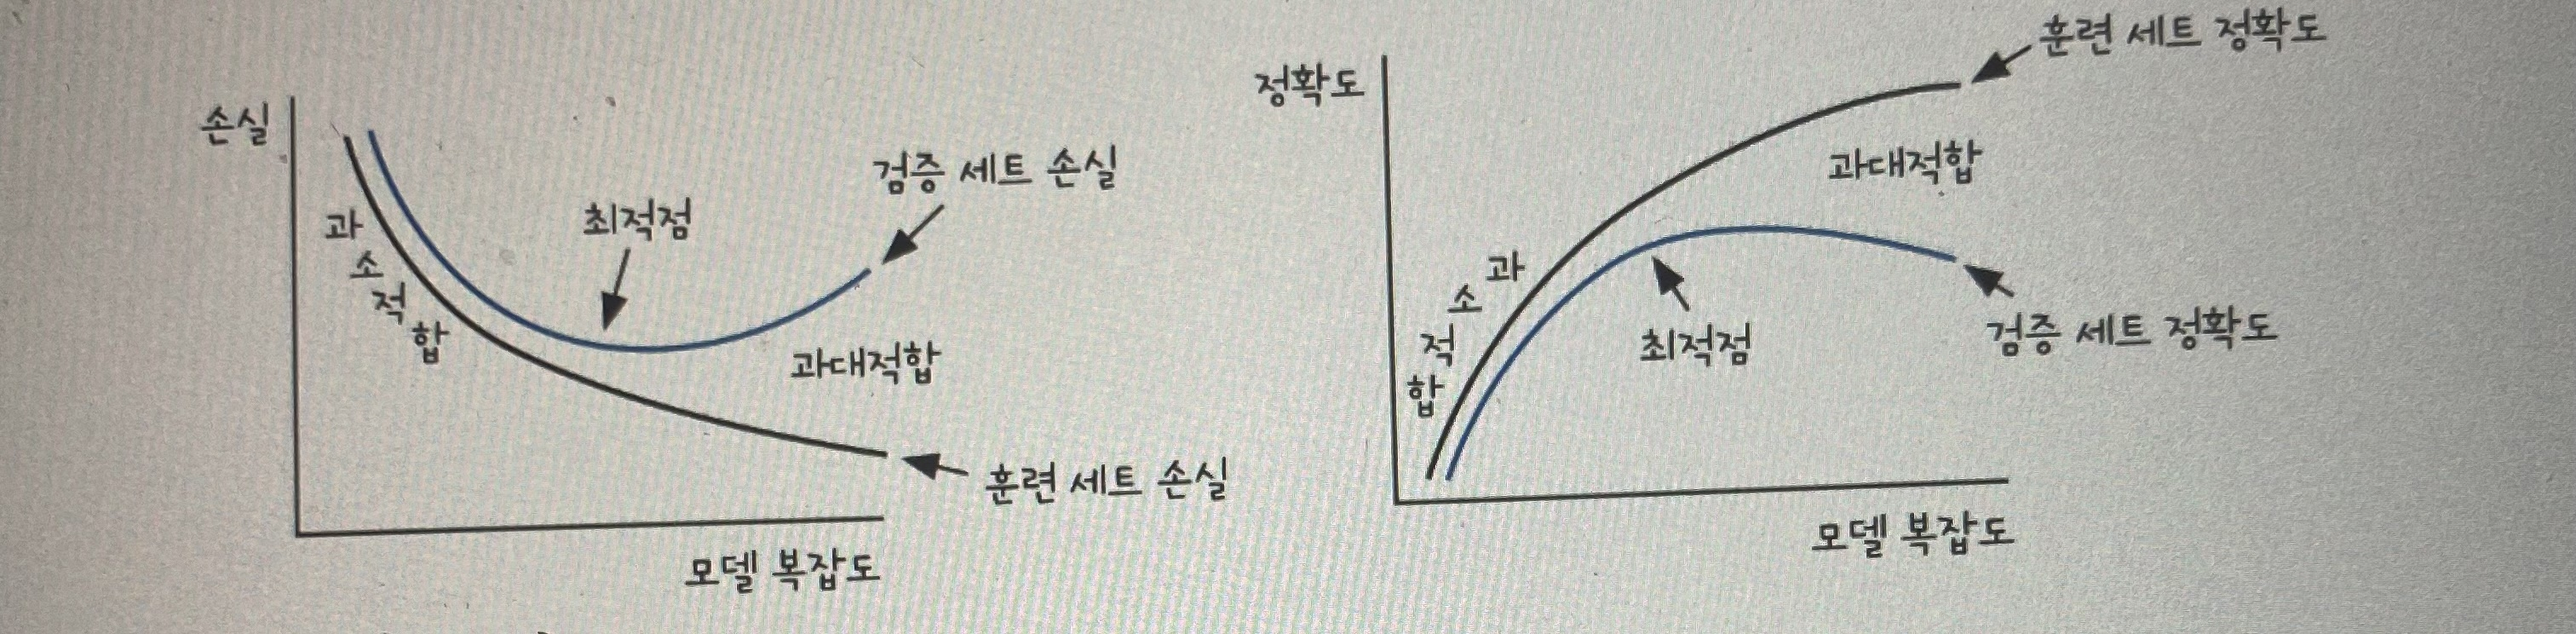

모델 복잡도 : 모델이 가진 학습 가능한 가중치 개수               
복잡한 모델이 무조건 좋지는 않다 => 훈련세트에만 잘 맞는 형태로 만들어지면 훈련 세트에서만 좋은 성능을 내기 때문 => 과대적합 유발


편향-분산 트레이드오프 : 과소적합된 모델(편향), 과대적합된 모델(분산) 사이의 관계              
편향을 줄이면(훈련세트의 성능을 높이면) 분산이 커지고(검증세트와 성능 차이가 커지고 분산을 줄이면 편향이 커지므로 적절한 중간 지점을 찾아야 한다.

In [ ]:
# 모델 복잡도를 조절하기 힘드므로
# 경사 하강법의 에포크 횟수에 대한 모델의 손실 그래프로 그려
# 최적점('적절한 편향-분산 트레이드오프')를 에포크로 찾겠다.

class SingleLayer:

  def __init__(self, learning_rate=0.1): 
    self.w = None 
    self.b = None
    self.losses = [] # 손실함수의 결과 값을 저장할 리스트
    self.val_losses = [] # 검증 손실을 기록할 변수 추가
    self.w_history = [] # 에포크마다 가중치의 값
    self.lr = learning_rate # 학습률 하이퍼 파라미터(learning_rate)(0.01, 0.001 등등 로그 스케일로 지정)

  def forpass(self, x):
    z = np.sum(x * self.w) + self.b     # 직선 방정식 계산
    return z
  
  def backprop(self, x, err):
    w_grad = x * err
    b_grad = 1 * err
    return w_grad, b_grad
  

  # 검증세트를 전달 받을 수 있게 x_val, y_val 변수 추가
  def fit(self, x, y, epochs=100, x_val=None, y_val=None):  

    self.w = np.ones(x.shape[1]) # 가중치를 초기화
    self.b = 0  # 절편을 초기화
    self.w_history.append(self.w.copy()) # 가중치를 기록
    np.random.seed(42) # 무작위로 시드를 지정

    for i in range(epochs):
      loss = 0
      indexes = np.random.permutation(np.arange(len(x))) # 인덱스 섞기

      for i in indexes: # 모든 샘플에 대해 반복
        z = self.forpass(x[i]) # 직선 방정식 적용( 정방향 계산 ) 
        a = self.activation(z) # 활성화 함수 적용
        err = -(y[i] - a); # 오차계산 => 로지스틱 손실 함수 미분값 
        w_grad, b_grad = self.backprop(x[i], err) # 역방향 계산
        self.w -= self.lr * w_grad # 가중치 업데이트(학습률 적용)
        self.b -= b_grad
        self.w_history.append(self.w.copy()) # 가중치 기록
        a = np.clip(a, 1e-10, 1-1e-10) # 안전한 로그 계산을 위해 클리핑 후 손실을 누적
        loss += -(y[i]*np.log(a) + (1-y[i]) * np.log(1-a))
      self.losses.append(loss/len(y))  # 에포크마다 평균 손실을 저장
      self.update_val_loss(x_val, y_val) # 검증 세트에 대한 손실을 계산
  
  def update_val_loss(self, x_val, y_val):
    if x_val is None:
      return
    val_loss = 0
    for i in range(len(x_val)):
      z = self.forpass(x_val[i])
      a = self.activation(z)
      a = np.clip(a, 1e-10, 1-1e-10)
      val_loss += -(y_val[i]*np.log(a) + (1-y_val[i]) * np.log(1-a))
    self.val_losses.append(val_loss / len(y_val))


  def activation(self, z): # 활성화 함수 구현 (z값은 np(배열)로 넘어옴)
    z = np.clip(z, -100, None)
    a = 1 / (1 + np.exp(-z)) # 시그모이드 함수
    return a
  
  def predict(self, x): # 예측 메서드 구현
    z = [self.forpass(x_i) for x_i in x] # 선형 함수 적용 
    return np.array(z) > 0 # 스템 함수 적용
    # z가 0보다 크면 시그모이드 함수의 출력값은 0.5보다 크고 작으면 0.5보다 작으므로 굳이 시그모이드 함수를 사용하지 않아도 된다.

  def score(self, x, y): # 정확도 출력 
    return np.mean(self.predict(x) ==  y)


In [ ]:
layer3 = SingleLayer()
layer3.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val)

In [ ]:
plt.ylim(0, 0.3)
plt.plot(layer3.losses)
plt.plot(layer3.val_losses) # 에포크 마다 검증 세트의 손실값
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()
# 약 20번째 에포크 부터 훈련세트보다 검증 세트가 높아짐 => 에포크가 진행됨에 따라 가중치는 훈련세트에 잘 맞게 되지만 검증세트에는 잘 맞지 않게 되는 것
# => 20번 이후 훈련할 필욕가 없다 !

NameError: ignored

In [ ]:
# 훈련을 조기 종료
layer4 = SingleLayer()
layer4.fit(x_train_scaled, y_train, epochs=20)
layer4.score(x_val_scaled, y_val)
# 과대 적합이 되기 전 대략의 최적점인 20에서 조기종료 했을 때 성능이 조금 더 향상됨 